In [1]:
import pandas as pd
import numpy as np
import copy
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


C:\Users\murad\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('HW1_var_18.csv', sep=';')
data= df.drop('Номер варианта', axis=1) #удалили служебный столбец
data.columns

Index(['ID', 'INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'DTI',
       'SEX', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'EDUCATION',
       'EMPL_TYPE', 'EMPL_SIZE', 'BANKACCOUNT_FLAG', 'Period_at_work', 'age',
       'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS', 'max90days', 'max60days',
       'max30days', 'max21days', 'max14days', 'avg_num_delay', 'if_zalog',
       'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60',
       'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed',
       'sum_of_paym_months', 'all_credits', 'Active_not_cc', 'own_closed',
       'min_MnthAfterLoan', 'max_MnthAfterLoan', 'dlq_exist',
       'thirty_in_a_year', 'sixty_in_a_year', 'ninety_in_a_year',
       'thirty_vintage', 'sixty_vintage', 'ninety_vintage'],
      dtype='object')

Итак, задачей моего домашнего задания является исследование банковских данных клиентов с целью последующей сегментации для формирования основных портретов клиентов.
Изначально до всех преобразований имеем 43 переменные (технический столбец с вариантом был сразу удален) и 10242 строки.


# Часть 1

Изначально python воспринимает только 10 переменных как категориальные, однако попробуем повнимательнее глянуть на признаки, может некоторые числовые, по мнению питона, признаки на самом деле являются категориальными.

In [3]:
data.dtypes #типы данных

ID                         int64
INCOME_BASE_TYPE          object
CREDIT_PURPOSE            object
INSURANCE_FLAG           float64
DTI                       object
SEX                       object
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                 object
EMPL_TYPE                 object
EMPL_SIZE                 object
BANKACCOUNT_FLAG         float64
Period_at_work           float64
age                      float64
EMPL_PROPERTY             object
EMPL_FORM                 object
FAMILY_STATUS             object
max90days                float64
max60days                float64
max30days                float64
max21days                float64
max14days                float64
avg_num_delay            float64
if_zalog                 float64
num_AccountActive180     float64
num_AccountActive90      float64
num_AccountActive60      float64
Active_to_All_prc        float64
numAccountActiveAll      float64
numAccountClosed         float64
sum_of_pay

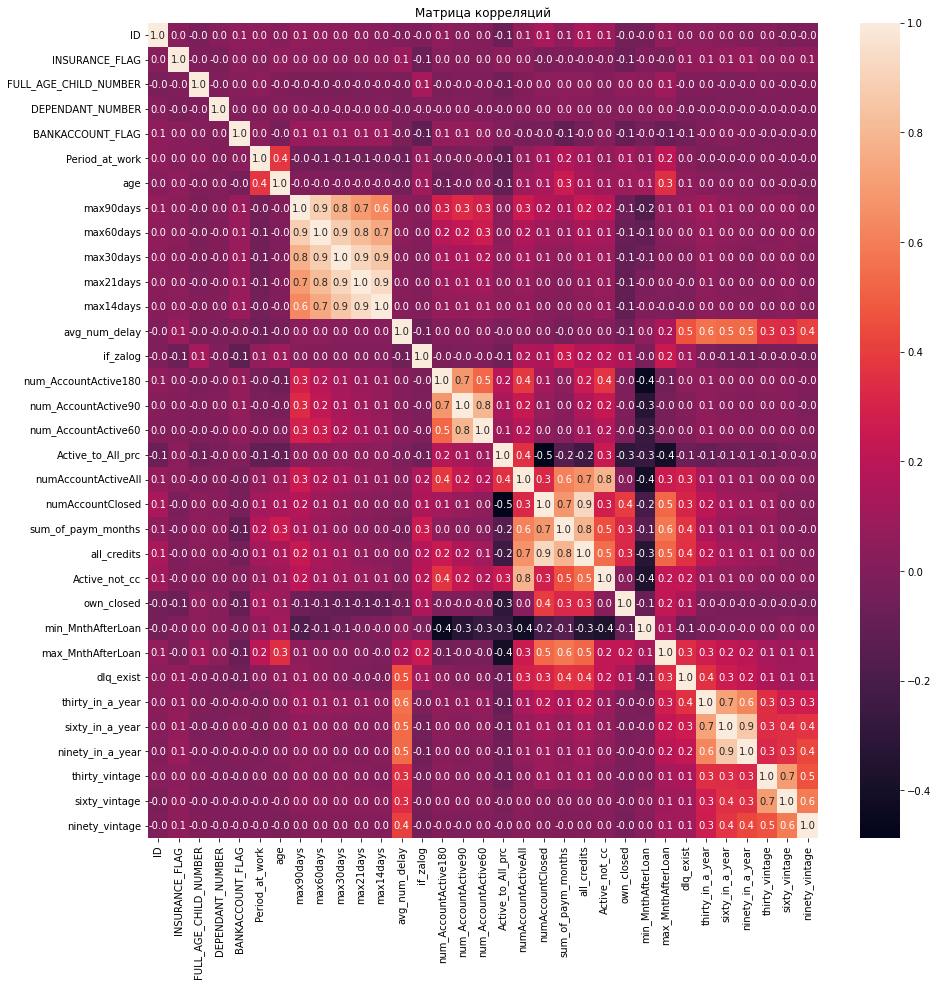

In [4]:
plt.figure(figsize = (15,15)) #до обработки пропусков и ошибок(смотрим ИЗНАЧАЛЬНУЮ корреляцию числовых колонок)
numeric_data = data.select_dtypes(include=[np.number]) 
plt.title('Матрица корреляций')
sns.heatmap(numeric_data.corr(), annot=True, fmt='.1f');


Между количественными переменными преобладает положительная зависимость. Некоторые переменные имеют очень высокую корреляцию, стремящуюся к 1, что может указывать на арифметическую зависимость, а не только на корреляционную. Отрицательная зависимость встречается реже, и корреляция по модулю не превышает 0,4, что говорит о наличии умеренной, но не сильной связи.

Особенно интересным является наблюдение о высокой корреляции между переменными "max90days", "max60days", "max30days", "max21days" и "max14days". Мы предположили, что переменная "max21days" включает в себя значения переменной "max14days" и так далее. Это может быть связано с тем, что эти переменные представляют количество запросов в бюро кредитных историй за последние N дней.

Также я обратила внимание на отрицательную корреляцию между переменными "Active_to_All_prc" и "numAccountClosed" (-0.5). Логично, что количество закрытых счетов напрямую и отрицательно влияет на общее число активных счетов.



Переводим некоторые числовые колонки в категориальные.
1) INSURANCE_FLAG -  1/0 в случае страхования/его отсутствия при взятии кредита

2) BANKACCOUNT_FLAG - количество онлайн-акков (0 - нет аккаунта, 1 - есть один акк, 2 - заходил в онлайн кабинет с другого устройства)

3) if_zalog - 1/0 в случае наличия/отсутствия залога

4) dlq_exist - 1/0 есть/нет просрочки

5) ninety_in_a_year - 1/0 в случае наличия/отсутствия просрочки на 90 дней за последний год

6) ninety_vintage - 1/0 в случае наличия/отсутствия 90+ дней просрочки когда-либо

7) sixty_in_a_year - 1/0 в случае наличия/отсутствия просрочки на 60 дней за последний год

8) sixty_vintage - 1/0 в случае наличия/отсутствия 60+ дней просрочки когда-либо

9) thirty_in_a_year - 1/0 в случае наличия/отсутствия просрочки на 30 дней за последний год

10) thirty_vintage - 1/0 в случае наличия/отсутствия 30+ дней просрочки когда-либо



In [5]:
data[['INSURANCE_FLAG', "BANKACCOUNT_FLAG",'if_zalog', 'dlq_exist','ninety_in_a_year','ninety_vintage','sixty_in_a_year',
      'sixty_vintage','thirty_vintage','thirty_in_a_year']]= data[['INSURANCE_FLAG', 'BANKACCOUNT_FLAG','if_zalog',
                                                                   'dlq_exist','ninety_in_a_year',
                                                                   'ninety_vintage','sixty_in_a_year', 'sixty_vintage',
                                                                   'thirty_vintage','thirty_in_a_year']].astype(object)
#поменяли тип колонок некоторых

Также заметим, что переменная DTI принимает много вещественных значений, вернем истинный тип колонке. Однако нашла в данных один странный элемент именно в этой колонке #Поле! (вероятно, при заполнении возникла ошибка), поэтому сразу удаляем эту строчку, можем рассматривать его как пропуск.

In [6]:
data.DTI.value_counts()

DTI
0.59      755
0.49      754
0.47      298
0.48      297
0.46      262
         ... 
0.03        2
#ПОЛЕ!      1
0.02        1
0.63        1
0           1
Name: count, Length: 62, dtype: int64

In [7]:
data = data[data.DTI != '#ПОЛЕ!'] 
data['DTI'] = data['DTI'].astype(float)
data.dtypes #итого у нас окончательно 19 категориальных фичей!

ID                         int64
INCOME_BASE_TYPE          object
CREDIT_PURPOSE            object
INSURANCE_FLAG            object
DTI                      float64
SEX                       object
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                 object
EMPL_TYPE                 object
EMPL_SIZE                 object
BANKACCOUNT_FLAG          object
Period_at_work           float64
age                      float64
EMPL_PROPERTY             object
EMPL_FORM                 object
FAMILY_STATUS             object
max90days                float64
max60days                float64
max30days                float64
max21days                float64
max14days                float64
avg_num_delay            float64
if_zalog                  object
num_AccountActive180     float64
num_AccountActive90      float64
num_AccountActive60      float64
Active_to_All_prc        float64
numAccountActiveAll      float64
numAccountClosed         float64
sum_of_pay

Посмотрим на изначальное распределение числовых колонок (до исследования, которое идет далее).


In [8]:
numerical_cols = data.select_dtypes(include=np.number) 
num_cols= numerical_cols.columns
numerical_cols.describe()

,ID,DTI,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,Period_at_work,age,max90days,max60days,max30days,max21days,...,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan
count,1.024100e+04,10113.000000,10241.000000,10241.000000,7876.000000,7877.000000,3913.000000,3913.000000,3913.000000,3913.000000,...,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000
mean,1.102433e+06,0.390752,0.558930,0.004785,65.264093,36.277644,1.644007,1.181191,0.884232,0.676208,...,0.103037,0.430029,2.232375,3.511388,80.768709,5.743764,1.117137,0.723156,13.668926,61.257592
std,5.913599e+04,0.136571,0.767166,0.087704,66.852692,8.551845,1.944600,1.605727,1.378011,1.195676,...,0.348909,0.284496,1.663261,3.217355,69.957424,4.070535,1.070526,1.092215,14.823203,30.445384
min,1.000018e+06,0.000000,0.000000,0.000000,6.000000,23.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000
25%,1.051218e+06,0.290000,0.000000,0.000000,19.000000,29.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,1.000000,1.000000,29.000000,3.000000,0.000000,0.000000,4.000000,35.000000
50%,1.102438e+06,0.410000,0.000000,0.000000,44.000000,34.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.400000,2.000000,3.000000,63.000000,5.000000,1.000000,0.000000,9.000000,67.000000
75%,1.153638e+06,0.490000,1.000000,0.000000,87.000000,42.000000,2.000000,2.000000,1.000000,1.000000,...,0.000000,0.600000,3.000000,5.000000,113.000000,8.000000,2.000000,1.000000,17.000000,87.000000
max,1.204838e+06,0.630000,6.000000,3.000000,1392.000000,61.000000,18.000000,16.000000,15.000000,14.000000,...,3.000000,1.000000,14.000000,28.000000,656.000000,34.000000,6.000000,17.000000,105.000000,172.000000


Еще раз посмотрим на корреляцию Пирсона после смены типы данных, будем наблюдать, как она меняется по ходу исследования. 


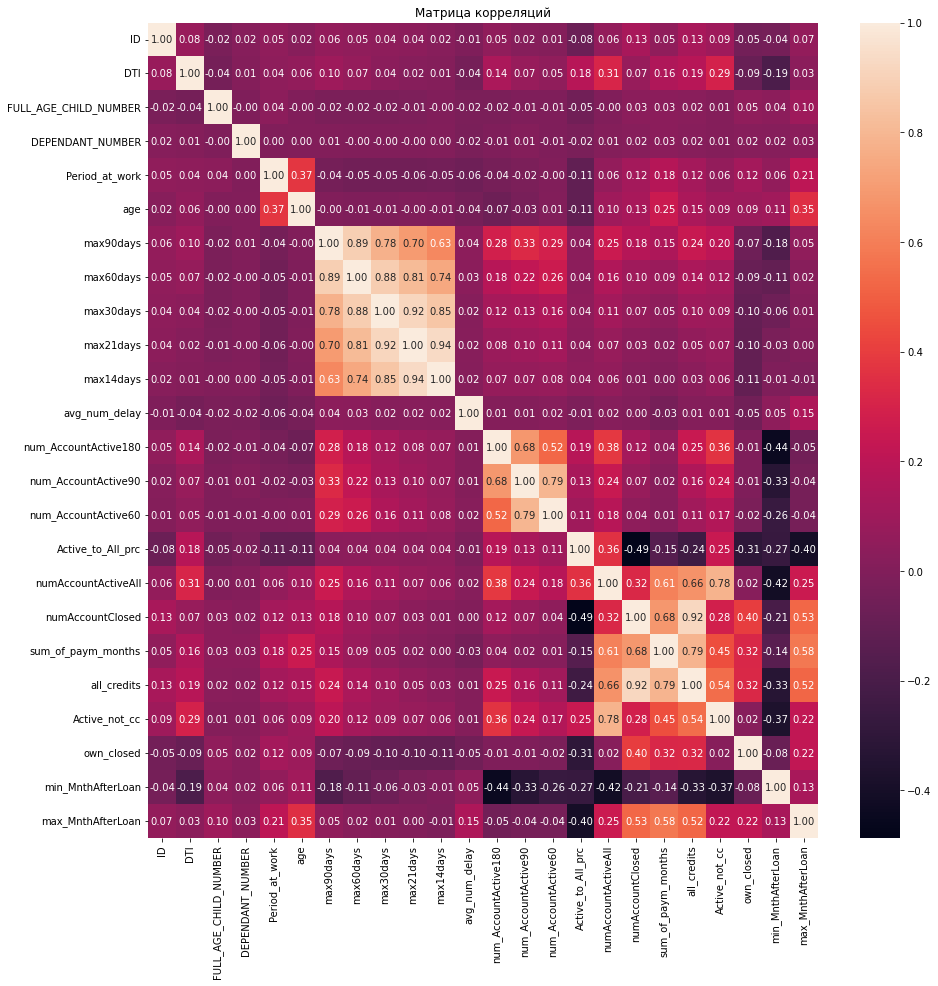

In [9]:
plt.figure(figsize = (15,15))
numeric_data = data.select_dtypes(include=[np.number]) 
plt.title('Матрица корреляций')
sns.heatmap(numeric_data.corr(), annot = True, fmt='.2f');

## Иследование распределения по данным

•
Рассчитываем кол во уникальных значений, нулевых и пустых значений + доля в от общего кол ва

•
Исследуем распределение данных по полу, возрасту и другим категориальным показателям

In [10]:
search = (
    data.isna().sum(axis=0).to_frame().rename(columns={0: 'Null'})
    .join((data.isna().sum(axis=0) / len(data) * 100).to_frame(), rsuffix='_right').rename(columns={0: '%Null'})
    .join(data.nunique(axis=0).to_frame().rename(columns={0: 'Unique'}))
    .join((data.nunique(axis=0) / len(data) * 100).to_frame().rename(columns={0: '%Unique'}))
    .join(data[data.eq(0)].count().to_frame().rename(columns={0: 'Zero'})).rename(columns={'0': '%Zero'})
    .join((data[data.eq(0)].count()/len(data)*100).to_frame().rename(columns = {0:'%Zero'}))
)
search

,Null,%Null,Unique,%Unique,Zero,%Zero
ID,0,0.000000,10241,100.000000,0,0.000000
INCOME_BASE_TYPE,68,0.663998,4,0.039059,0,0.000000
CREDIT_PURPOSE,0,0.000000,10,0.097647,0,0.000000
INSURANCE_FLAG,2,0.019529,2,0.019529,3999,39.048921
DTI,128,1.249878,61,0.595645,1,0.009765
SEX,0,0.000000,2,0.019529,0,0.000000
FULL_AGE_CHILD_NUMBER,0,0.000000,7,0.068353,6061,59.183673
DEPENDANT_NUMBER,0,0.000000,4,0.039059,10206,99.658237
EDUCATION,0,0.000000,9,0.087882,0,0.000000
EMPL_TYPE,5,0.048823,9,0.087882,0,0.000000


Общее количество строк: 10241 (напоминаю, что удалили одну строчку выше).

**Можно отметить следующие наблюдения:**

Доля уникальных значений для категориальных переменных очень низкая, почти все значения равны 0. Это ожидаемо для категориальных переменных, но необычно для числовых переменных.

В то же время, доля пропущенных значений гораздо выше:

У большинства переменных доля пропущенных значений превышает 61%.

Доля нулевых значений варьируется от 10% до 37% у большинства переменных.

Максимальное значение доли нулевых значений практически равно 100% и относится к переменной "DEPENDANT_NUMBER" (количество иждивенцев).

In [11]:
data.describe().T #посмотрим на распределение новых числовых колонок до обработки нулей и пропусков

,count,mean,std,min,25%,50%,75%,max
ID,10241.0,1.102433e+06,59135.993833,1000018.0,1051218.00,1.102438e+06,1.153638e+06,1.204838e+06
DTI,10113.0,3.907525e-01,0.136571,0.0,0.29,4.100000e-01,4.900000e-01,6.300000e-01
FULL_AGE_CHILD_NUMBER,10241.0,5.589298e-01,0.767166,0.0,0.00,0.000000e+00,1.000000e+00,6.000000e+00
DEPENDANT_NUMBER,10241.0,4.784689e-03,0.087704,0.0,0.00,0.000000e+00,0.000000e+00,3.000000e+00
Period_at_work,7876.0,6.526409e+01,66.852692,6.0,19.00,4.400000e+01,8.700000e+01,1.392000e+03
age,7877.0,3.627764e+01,8.551845,23.0,29.00,3.400000e+01,4.200000e+01,6.100000e+01
max90days,3913.0,1.644007e+00,1.944600,0.0,0.00,1.000000e+00,2.000000e+00,1.800000e+01
max60days,3913.0,1.181191e+00,1.605727,0.0,0.00,1.000000e+00,2.000000e+00,1.600000e+01
max30days,3913.0,8.842320e-01,1.378011,0.0,0.00,0.000000e+00,1.000000e+00,1.500000e+01
max21days,3913.0,6.762075e-01,1.195676,0.0,0.00,0.000000e+00,1.000000e+00,1.400000e+01


Посмотрим на распределение категориальных переменных на гистограммах. Для меня это не очень удобно, поэтому посмотрю на распределение каждой переменной отдельно с точным количеством категорий в ней в ячейках ниже.

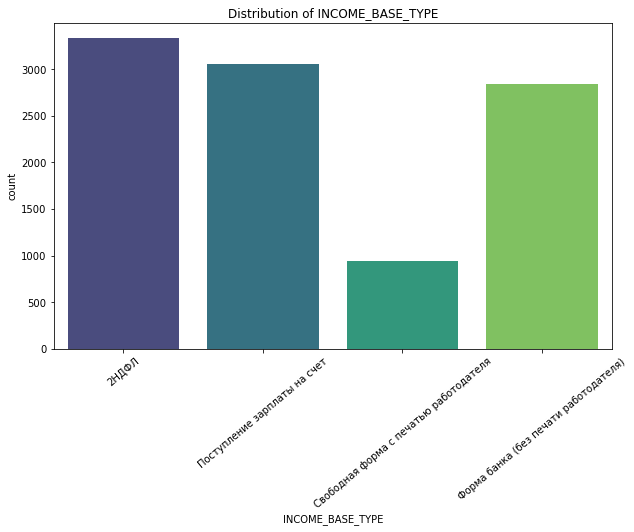

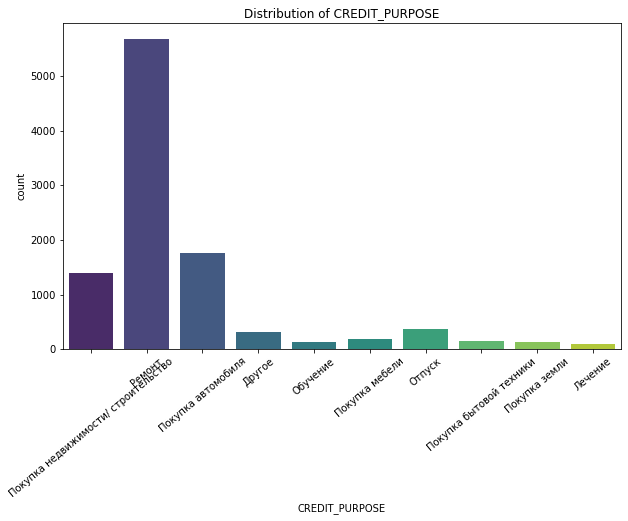

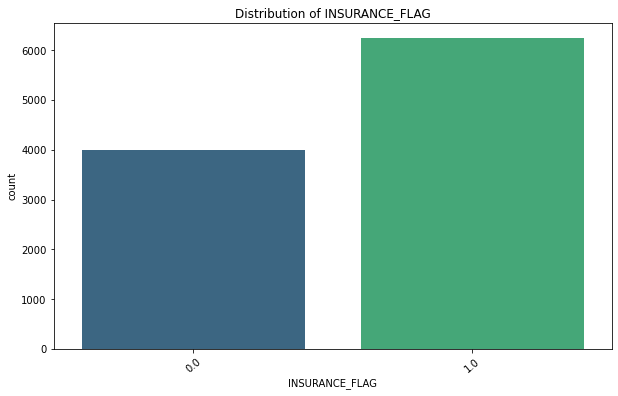

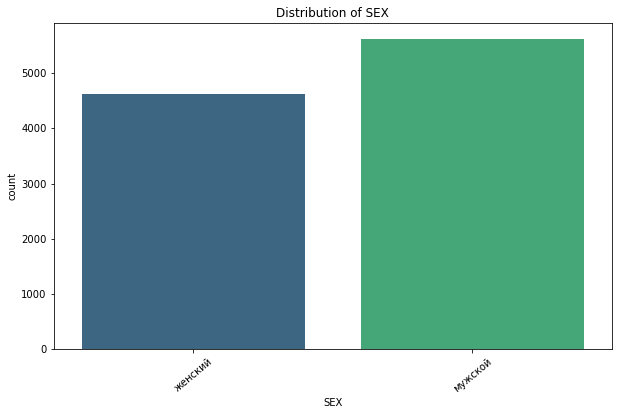

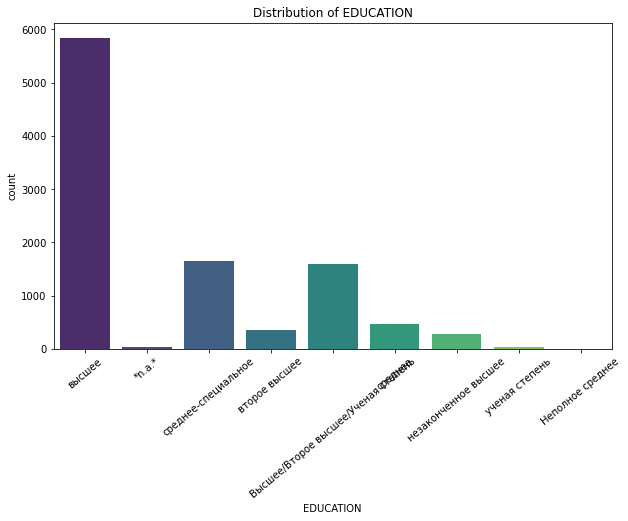

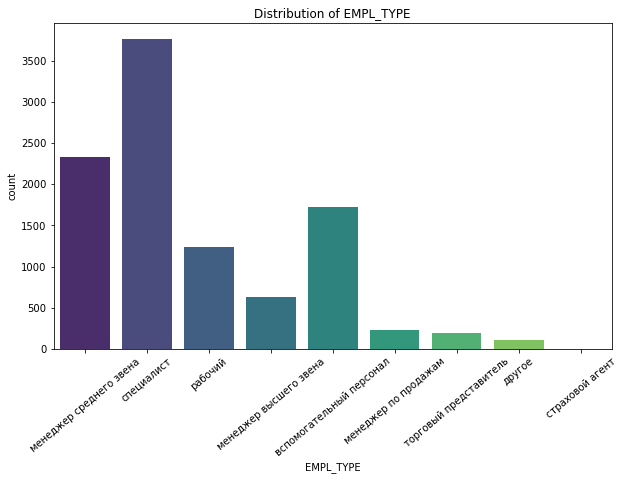

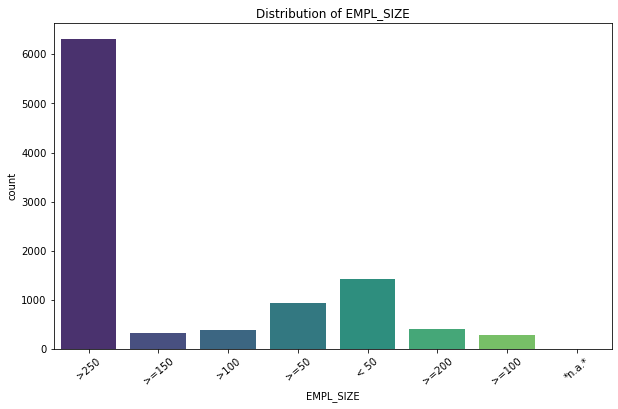

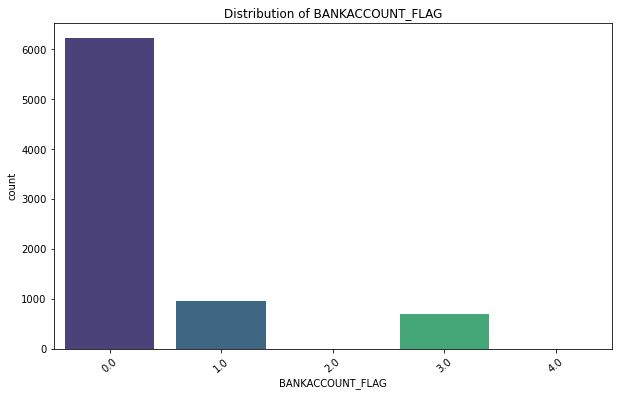

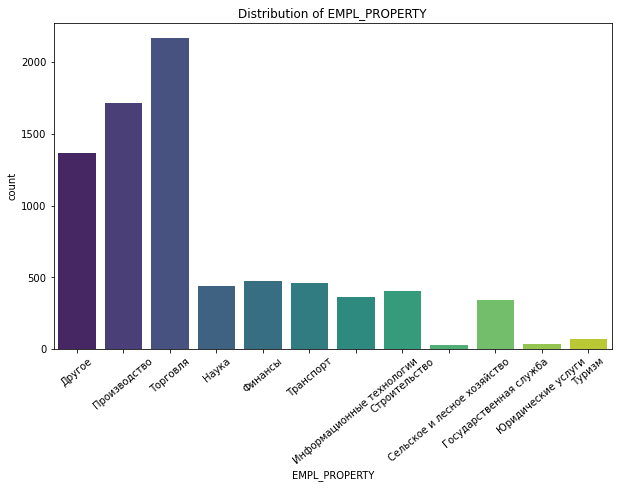

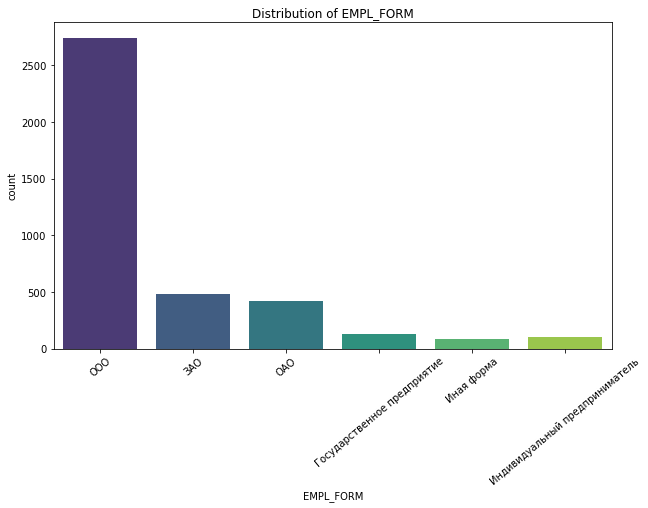

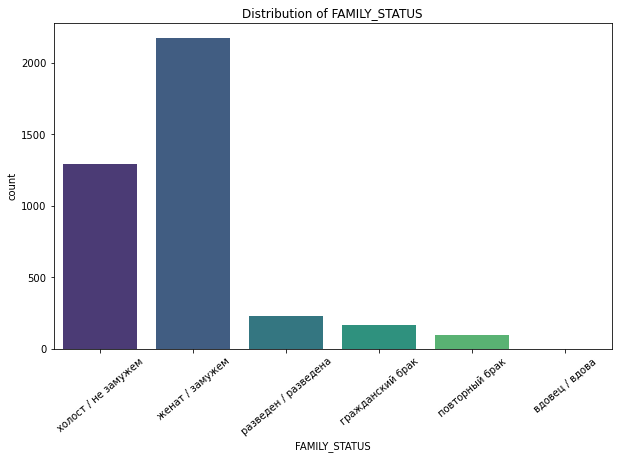

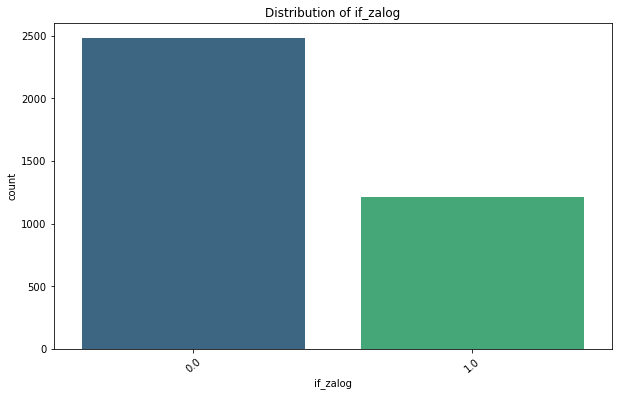

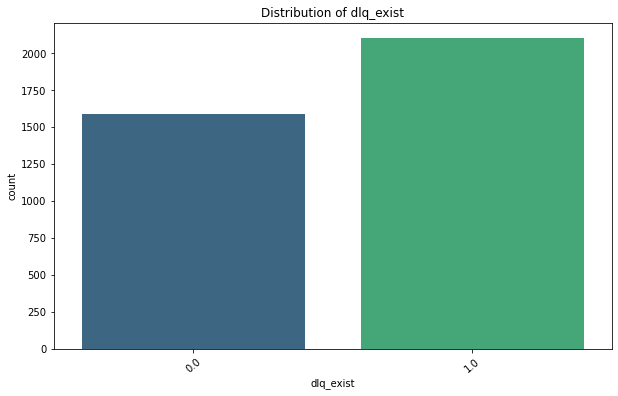

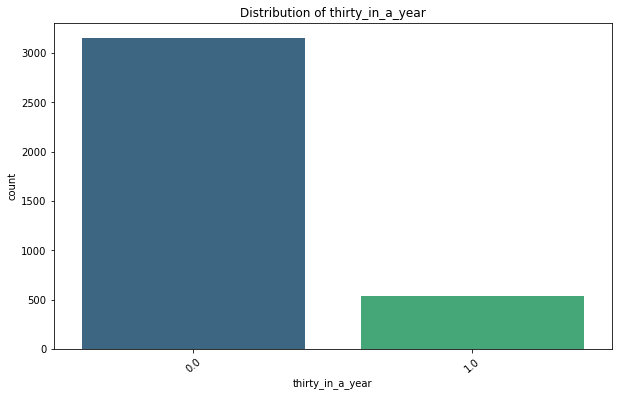

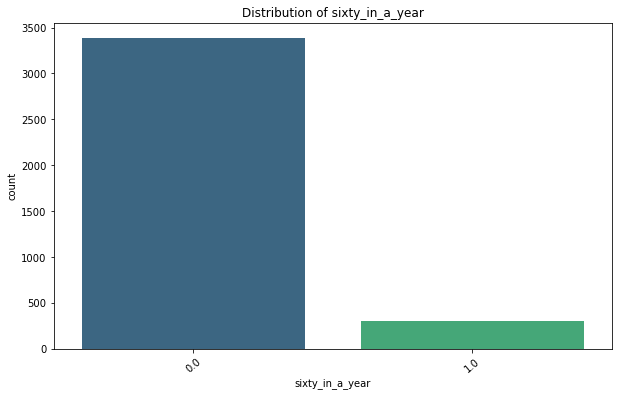

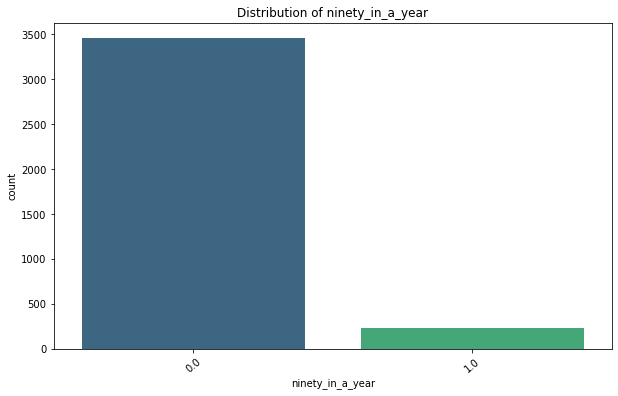

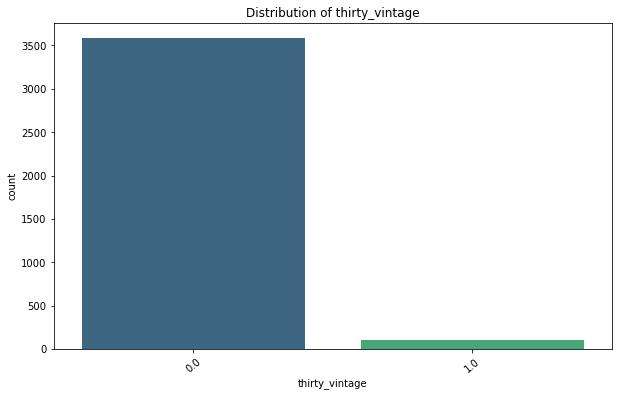

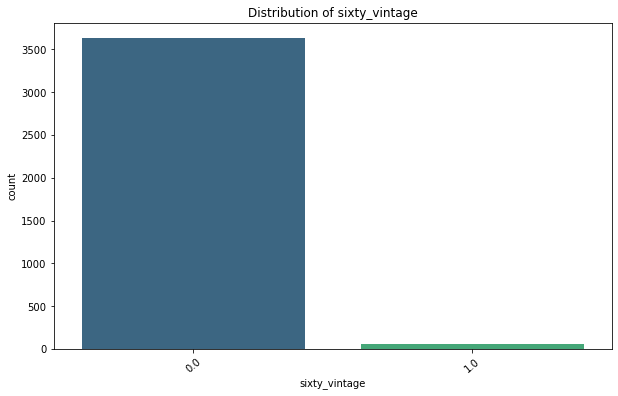

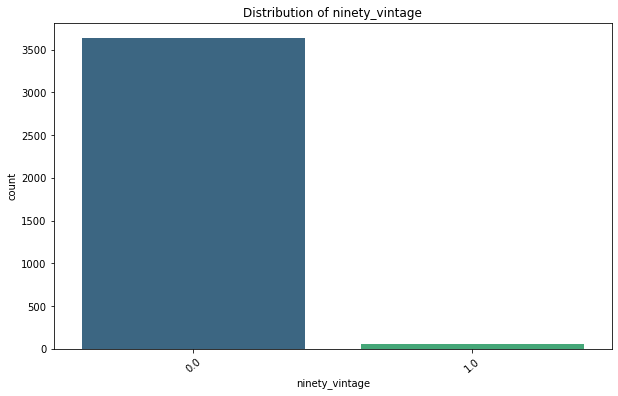

In [12]:
categorical_cols = data.select_dtypes(include='object')
for column in categorical_cols.columns:
    plt.figure(figsize=(10, 6)) 
    sns.countplot(data=categorical_cols, x=column, palette='viridis')  
    plt.xticks(rotation=40)  
    plt.title(f'Distribution of {column}')  
    plt.show()

In [13]:
data.SEX.value_counts() #больше мужских пользователей преобладает в нашей таблице, у всех пользователей известен пол

SEX
мужской    5623
женский    4618
Name: count, dtype: int64

In [14]:
data.INCOME_BASE_TYPE.value_counts() #принимает 4 различных значения

INCOME_BASE_TYPE
2НДФЛ                                     3330
Поступление зарплаты на счет              3055
Форма банка (без печати работодателя)     2842
Свободная форма с печатью работодателя     946
Name: count, dtype: int64

In [15]:
data.INSURANCE_FLAG.value_counts() #2 значения (есть еще 2 пропуска)

INSURANCE_FLAG
1.0    6240
0.0    3999
Name: count, dtype: int64

In [16]:
data.CREDIT_PURPOSE.value_counts() #10 различных значений, пропусков нет

CREDIT_PURPOSE
Ремонт                                 5685
Покупка автомобиля                     1766
Покупка недвижимости/ строительство    1404
Отпуск                                  368
Другое                                  320
Покупка мебели                          186
Покупка бытовой техники                 148
Покупка земли                           135
Обучение                                130
Лечение                                  99
Name: count, dtype: int64

In [17]:
data.EMPL_SIZE.value_counts() #надо будет объединить категории >100 и >=100

EMPL_SIZE
>250      6318
< 50      1432
>=50       945
>=200      404
>100       394
>=150      329
>=100      292
*n.a.*       1
Name: count, dtype: int64

In [18]:
data.BANKACCOUNT_FLAG.value_counts()  #объединим категории 3 и 4 в категорию общую - 2, 
                                      #так как в самом начале выяснили, что 2+ означает вход с другого устройства в акк

BANKACCOUNT_FLAG
0.0    6217
1.0     962
3.0     691
4.0       5
2.0       2
Name: count, dtype: int64

In [19]:
data.EDUCATION.value_counts() #видим, что бОльшая часть клиентов точно имеет высшее образование

EDUCATION
высшее                                 5831
среднее-специальное                    1645
Высшее/Второе высшее/Ученая степень    1599
среднее                                 467
второе высшее                           349
незаконченное высшее                    284
ученая степень                           33
*n.a.*                                   31
Неполное среднее                          2
Name: count, dtype: int64

In [20]:
data.EMPL_PROPERTY.value_counts() #помимо пропусков (2364), еще 12 категорий

EMPL_PROPERTY
Торговля                       2165
Производство                   1714
Другое                         1370
Финансы                         478
Транспорт                       463
Наука                           438
Строительство                   408
Информационные технологии       360
Государственная служба          344
Туризм                           73
Юридические услуги               38
Сельское и лесное хозяйство      26
Name: count, dtype: int64

In [21]:
data.EMPL_FORM.value_counts() #6 различных значений, помимо пропусков 

EMPL_FORM
ООО                               2739
ЗАО                                482
ОАО                                420
Государственное предприятие        129
Индивидуальный предприниматель     102
Иная форма                          87
Name: count, dtype: int64

In [22]:
data.FAMILY_STATUS.value_counts() #мода - женат/замужем

FAMILY_STATUS
женат / замужем         2172
холост / не замужем     1295
разведен / разведена     226
гражданский брак         166
повторный брак            99
вдовец / вдова             1
Name: count, dtype: int64

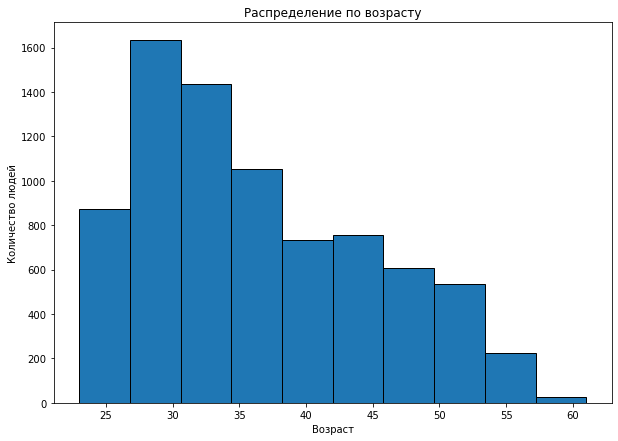

In [23]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot (111)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
ax.hist (data.age, edgecolor='black', bins = 10)
plt.show()

Видим, что наши клиенты, по большей части, "молодежь". Распределение по возрасту неравномерное.

Исправляем технические ошибки, возникшие при сборке данных, объединяем категории для BANKACCOUNT_FLAG.

In [29]:
data = data.replace(['*n.a.*'], [None]).replace(['>100'], ['>=100']).replace(['< 50'], ['<50'])
data.BANKACCOUNT_FLAG = data.BANKACCOUNT_FLAG.replace([3, 4], 2)

#возьмем рандомные колонки с одинаковыми значениями пропусков
lil_df=data[['if_zalog','max_MnthAfterLoan','sixty_vintage', 
             'ninety_in_a_year','dlq_exist', 'EDUCATION' , 'INSURANCE_FLAG']] 
lil_df[lil_df.isnull().any(axis=1)] #убедились, что строки с пропусками совпадают 
                               #(перепроверила и с другими признаками с большим количеством None - совпадение точное)
 

,if_zalog,max_MnthAfterLoan,sixty_vintage,ninety_in_a_year,dlq_exist,EDUCATION,INSURANCE_FLAG
0,NaN,NaN,NaN,NaN,NaN,высшее,0.0
1,NaN,NaN,NaN,NaN,NaN,высшее,0.0
2,NaN,NaN,NaN,NaN,NaN,None,1.0
3,NaN,NaN,NaN,NaN,NaN,среднее-специальное,1.0
4,NaN,NaN,NaN,NaN,NaN,высшее,1.0
...,...,...,...,...,...,...,...
10234,NaN,NaN,NaN,NaN,NaN,высшее,1.0
10237,NaN,NaN,NaN,NaN,NaN,высшее,0.0
10238,NaN,NaN,NaN,NaN,NaN,Высшее/Второе высшее/Ученая степень,1.0
10239,NaN,NaN,NaN,NaN,NaN,Высшее/Второе высшее/Ученая степень,0.0


Исходя из вышеизложенного о пропущенных значениях в категориальных переменных, можно принять решение удалить строки, в которых пропущена значительная часть переменных. Это решение является более предпочтительным, поскольку восстановление значений для категориальных переменных может привести к искажениям и ошибкам в данных.
Я понимаю, что удаление большого числа данных (которые чаще всего нелегко собираются), не приветствуется. Однако основная задача этого домашнего задания не построить модель, например, кредитного скоринга, а составление полных профилей клиентов по максимально полным, не придуманным данным транзакционной истории.
Сложно додумывать за клиентов, у которых пропущена бОльшая часть важных для нас переменных, заполнять их, например, средними (или любыми константами) по столбцам тоже нехорошо, так как среднее  очень сильно искажается от истины и не является состоятельной оценкой (это может повлиять на обучение моделей и качество в результате), поэтому я приняла решение удалить эти строки и работать с практически полным датасетом. 



In [30]:
data_cleaned = data.dropna(subset=['if_zalog', 'EDUCATION', 'INSURANCE_FLAG'])
data_cleaned

,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
6,1000138,Поступление зарплаты на счет,Покупка автомобиля,1.0,0.59,женский,0,0,высшее,специалист,...,0.0,8.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1000238,Поступление зарплаты на счет,Ремонт,0.0,0.56,женский,1,0,второе высшее,менеджер среднего звена,...,1.0,10.0,92.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
14,1000298,Поступление зарплаты на счет,Ремонт,0.0,0.21,женский,0,0,высшее,специалист,...,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1000338,Поступление зарплаты на счет,Покупка автомобиля,0.0,0.38,мужской,1,0,высшее,вспомогательный персонал,...,2.0,25.0,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1000438,Поступление зарплаты на счет,Ремонт,0.0,0.52,мужской,0,0,высшее,специалист,...,4.0,9.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,1204658,Форма банка (без печати работодателя),Ремонт,1.0,0.33,женский,0,0,среднее-специальное,вспомогательный персонал,...,0.0,1.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10233,1204678,Свободная форма с печатью работодателя,Ремонт,1.0,0.59,женский,0,0,Высшее/Второе высшее/Ученая степень,специалист,...,0.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10235,1204718,2НДФЛ,Покупка автомобиля,1.0,0.59,женский,0,0,высшее,специалист,...,1.0,3.0,29.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
10236,1204738,Форма банка (без печати работодателя),Ремонт,1.0,0.55,женский,1,0,среднее-специальное,вспомогательный персонал,...,0.0,9.0,96.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Итак:

1) Во всем датафрейме заменяем значение "*n.a.*" на пропуски.

2) В переменной EMPL_SIZE (Зарплата) заменяем значение ">100" на ">= 100".

3) В переменной BANKACCOUNT_FLAG (Количество аккаунтов у клиента) заменяем значения 3 и 4 на 2.

4) Удаляем строку с пропущенным значением (6553) в переменной if_zalog. Также удаляем пропущенные значения в переменных EDUCATION и INSURANCE_FLAG из оставшегося датафрейма. Всего было удалено 6569 строк.

5) Проанализируем ниже количественные переменные и оставшиеся пропуски в категориальных переменных в полученном датафрейме из 3672 строк. Заметим, что количество пропусков у всех переменных уменьшилось, а не только у категориальных переменных. В новом датафрейме практически нет пропущенных значений, что означает более полные данные для оставшихся 3672 клиентов. То небольшое количество пропусков, которые остались у количественных переменных, будем заменять либо на среднее, либо на медиану или моду.

In [31]:
data_cleaned[['INSURANCE_FLAG', "BANKACCOUNT_FLAG",'if_zalog', 'dlq_exist','ninety_in_a_year','ninety_vintage','sixty_in_a_year',
      'sixty_vintage','thirty_vintage','thirty_in_a_year']]= data_cleaned[['INSURANCE_FLAG', 'BANKACCOUNT_FLAG','if_zalog',
                                                                   'dlq_exist','ninety_in_a_year',
                                                                   'ninety_vintage','sixty_in_a_year', 'sixty_vintage',
                                                                   'thirty_vintage','thirty_in_a_year']].astype(object)

In [32]:
search2 = (
    data_cleaned.isna().sum(axis=0).to_frame().rename(columns={0: 'Null'})
    .join((data_cleaned.isna().sum(axis=0) / len(data_cleaned) * 100).to_frame(), rsuffix='_right').rename(columns={0: '%Null'})
    .join(data_cleaned.nunique(axis=0).to_frame().rename(columns={0: 'Unique'}))
    .join((data_cleaned.nunique(axis=0) / len(data_cleaned) * 100).to_frame().rename(columns={0: '%Unique'}))
    .join(data_cleaned[data_cleaned.eq(0)].count().to_frame().rename(columns={0: 'Zero'})).rename(columns={'0': '%Zero'})
    .join((data_cleaned[data_cleaned.eq(0)].count()/len(data_cleaned)*100).to_frame().rename(columns = {0:'%Zero'}))
)
search2 #обработали все пропуски категориальных фичей

,Null,%Null,Unique,%Unique,Zero,%Zero
ID,0,0.000000,3672,100.000000,0,0.000000
INCOME_BASE_TYPE,0,0.000000,4,0.108932,0,0.000000
CREDIT_PURPOSE,0,0.000000,10,0.272331,0,0.000000
INSURANCE_FLAG,0,0.000000,2,0.054466,1422,38.725490
DTI,0,0.000000,57,1.552288,0,0.000000
SEX,0,0.000000,2,0.054466,0,0.000000
FULL_AGE_CHILD_NUMBER,0,0.000000,7,0.190632,2281,62.118736
DEPENDANT_NUMBER,0,0.000000,3,0.081699,3661,99.700436
EDUCATION,0,0.000000,7,0.190632,0,0.000000
EMPL_TYPE,0,0.000000,9,0.245098,0,0.000000


In [33]:
data_cleaned.EMPL_SIZE.value_counts() #заметим, что в данном столбце осталось всего две категории после удаления пропусков

EMPL_SIZE
>250    2797
<50      875
Name: count, dtype: int64

Также стоит отметить, что вторым наиболее часто встречающимся значением переменной является смешенное значение "Высшее/Второе высшее/Ученая степень", 
которое объединяет в себе три других значения. Удаление этих значений не является возможным, так как их количество слишком велико.
Также объединение этого значения с другими может быть некорректным. Наши клиенты чаще всего имеют, как минимум, средний уровень образования.

In [34]:
data_cleaned.EDUCATION.value_counts()


EDUCATION
высшее                                 2118
Высшее/Второе высшее/Ученая степень     612
среднее-специальное                     536
среднее                                 155
второе высшее                           122
незаконченное высшее                    117
ученая степень                           12
Name: count, dtype: int64

In [59]:
id_column=data_cleaned.ID
data_cleaned.drop('ID', axis=1, inplace= True)

Теперь либо заполним пропуски у количественных переменных (если они есть из таблицы выше), либо удалим эти пропуски.
Заметим, что пропуски в одних и тех же строках по этим  переменным.
Это объясняется тем, что между указанными переменными в датафрейме существует прямая связь или взаимозависимость, 
как уже было отмечено ранее. Заметим пропуски на средние значения по столбцам.

In [60]:
data_cleaned[data_cleaned[['max90days', 'max60days', 'max30days', 'max21days', 'max14days']].isna().any(axis=1)]


,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage


In [61]:
data_cleaned[['max90days', 'max60days', 'max30days', 'max21days', 'max14days']]= data_cleaned[['max90days',
                                                                          'max60days', 'max30days', 'max21days', 'max14days']] .fillna(data_cleaned[['max90days', 
                                                                                                                                          'max60days', 'max30days', 'max21days', 'max14days']].mean())


In [62]:
data_cleaned['avg_num_delay'].fillna(data_cleaned['avg_num_delay'].mean(), inplace=True)
data_cleaned.avg_num_delay.isna().sum() #заменили 12 пропусков также на среднее значение

0

Корреляция немного изменилась после чистки пропусков. Теперь между некоторыми логически связанными переменными более заметна связь.

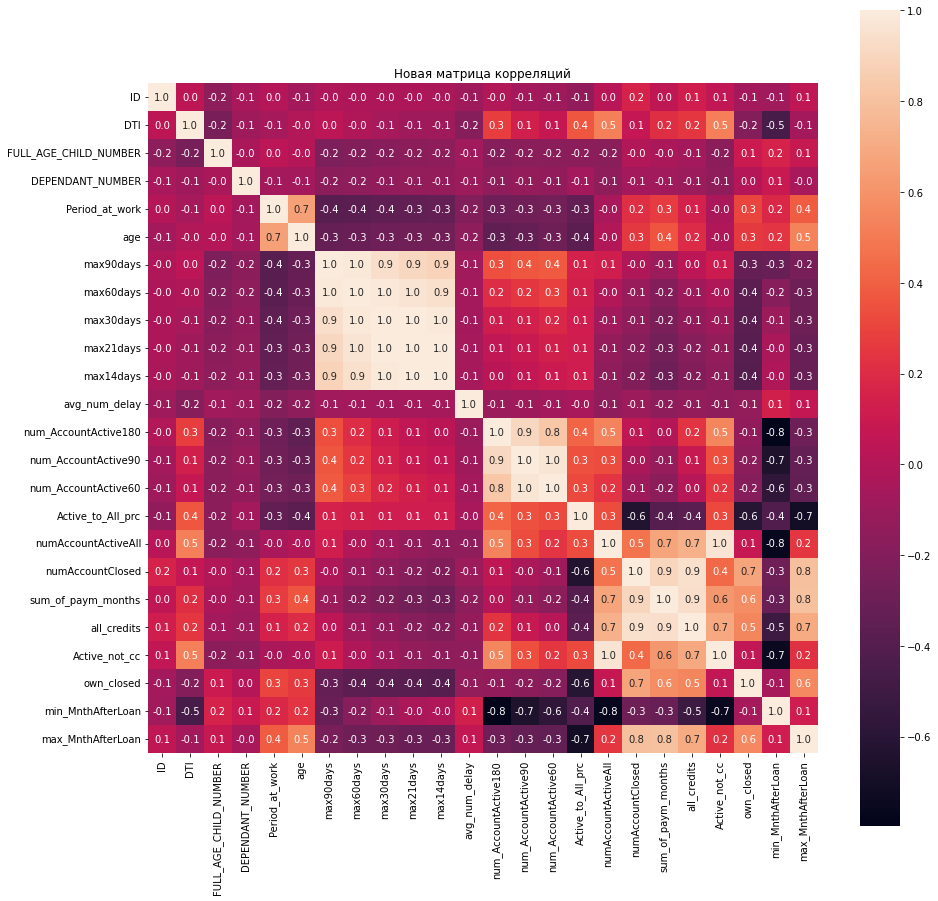

In [39]:
plt.figure(figsize = (15,15)) 
numeric_data = data_cleaned.select_dtypes(include=[np.number]) 

plt.title('Новая матрица корреляций')
sns.heatmap(numeric_data.corr().corr(method='pearson'), 
            square=True, annot=True, fmt=".1f" );

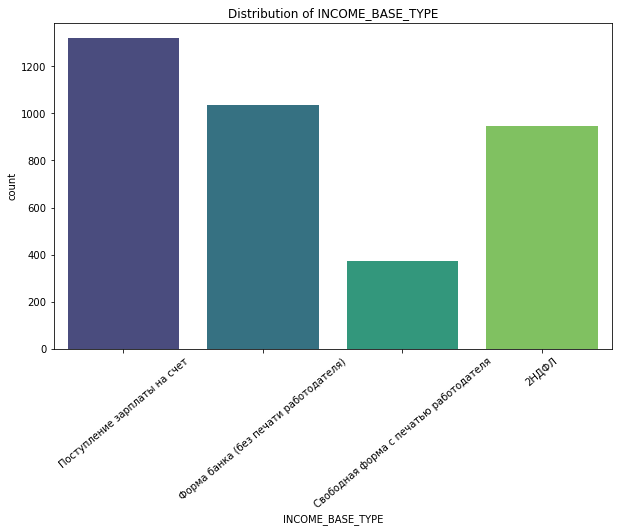

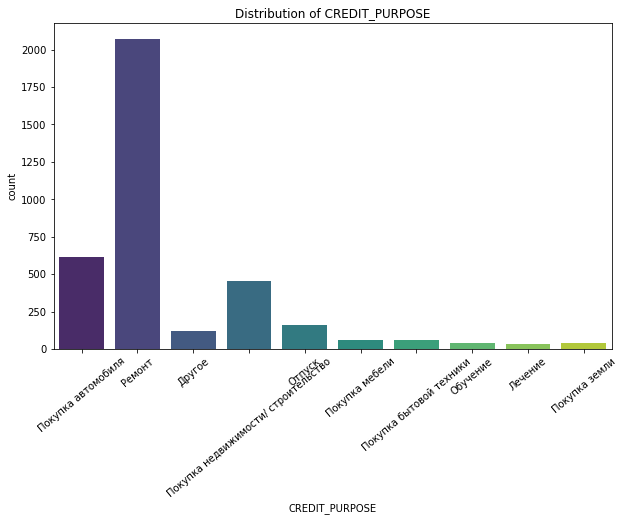

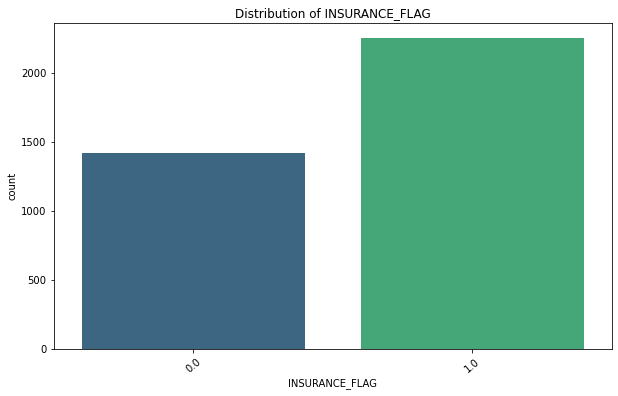

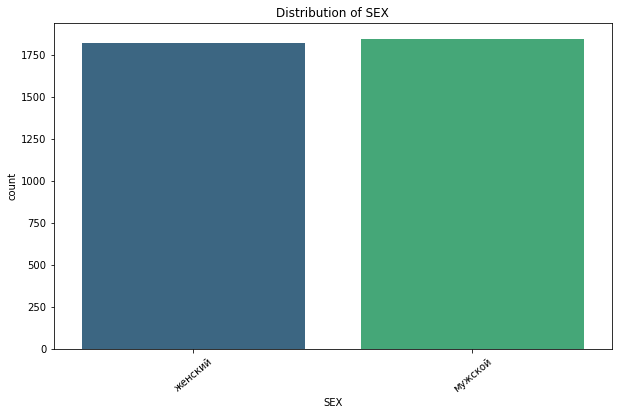

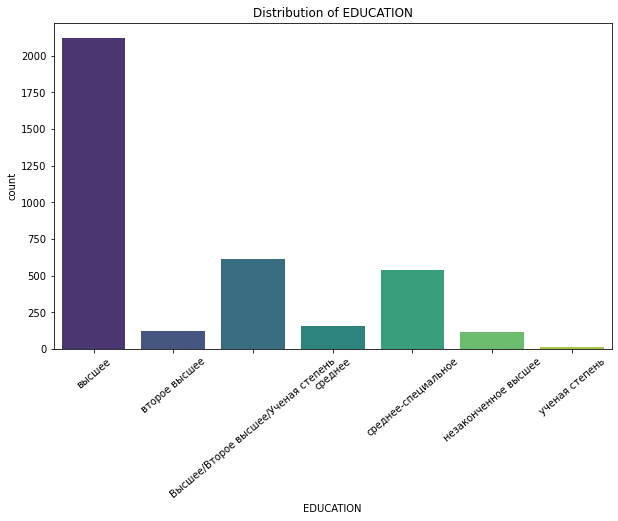

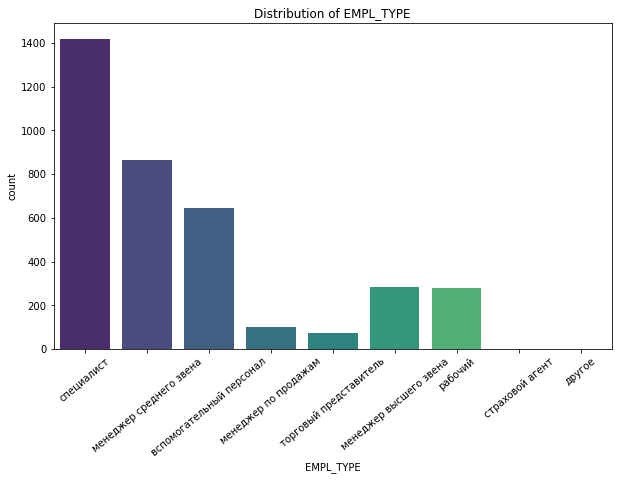

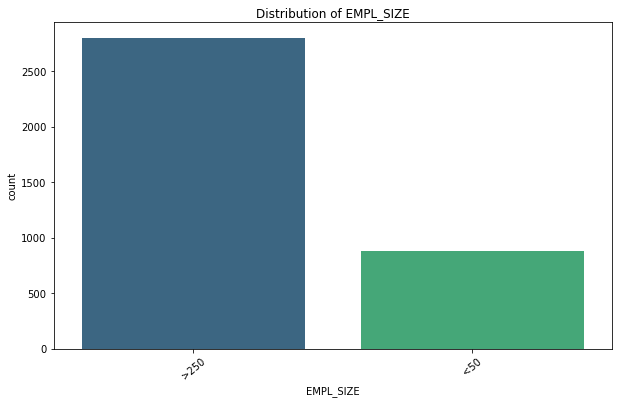

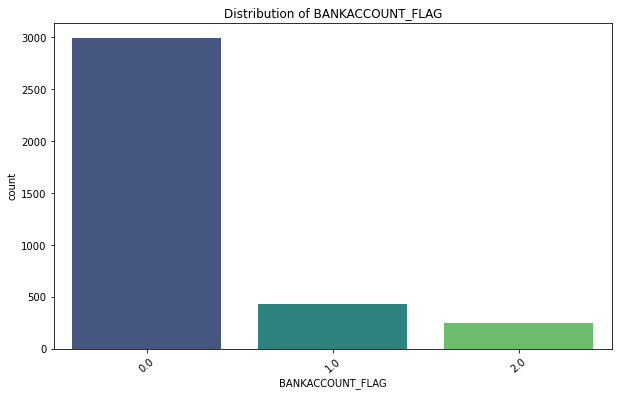

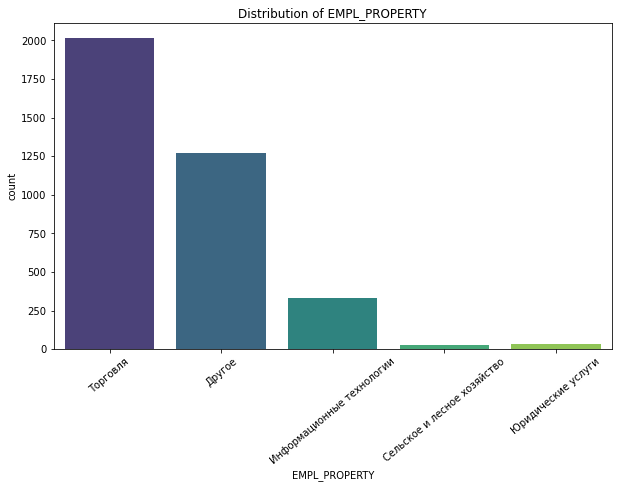

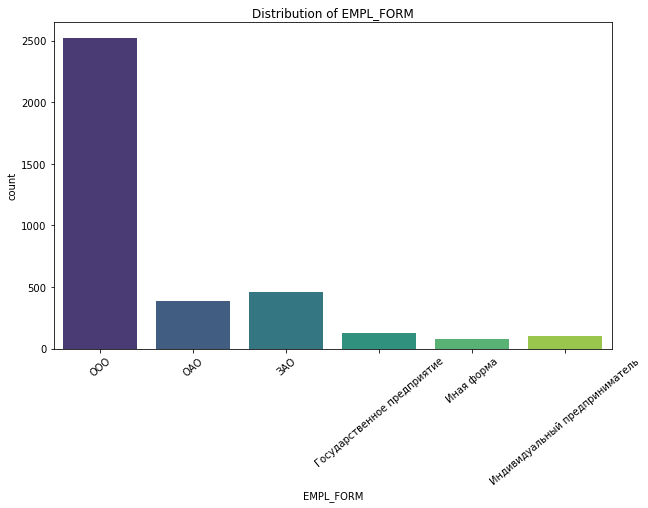

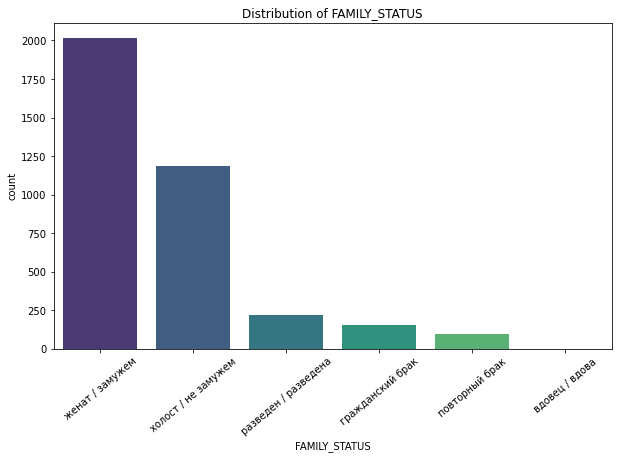

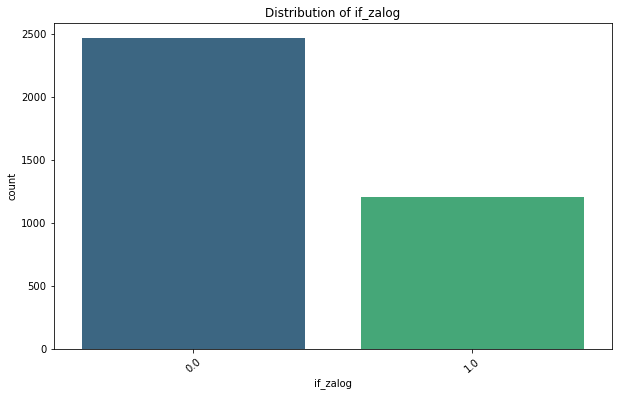

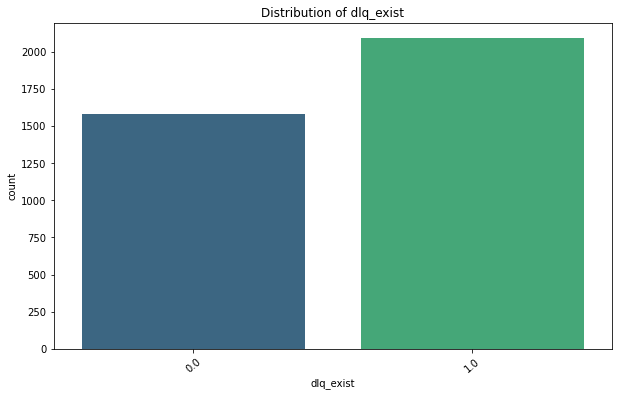

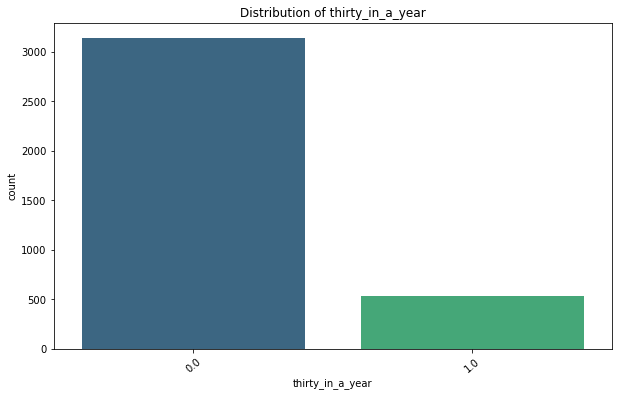

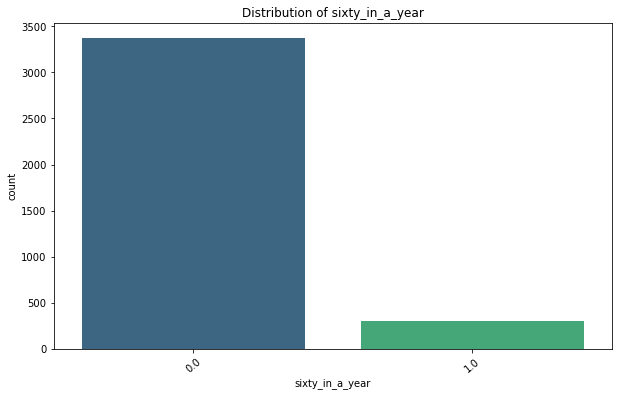

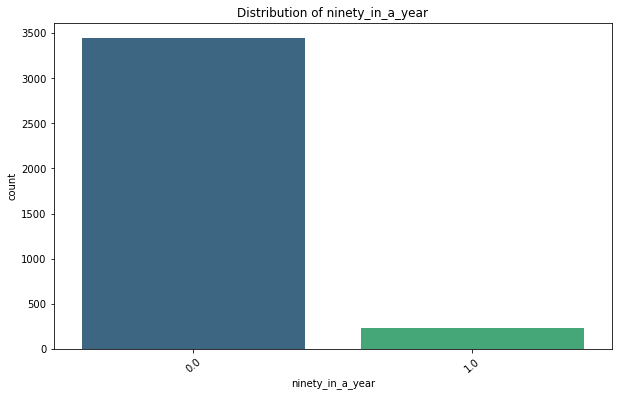

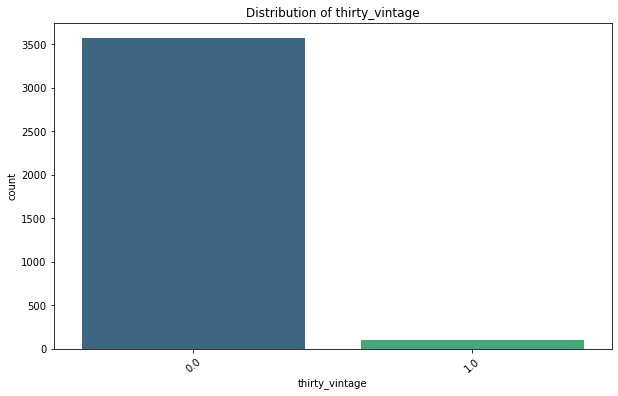

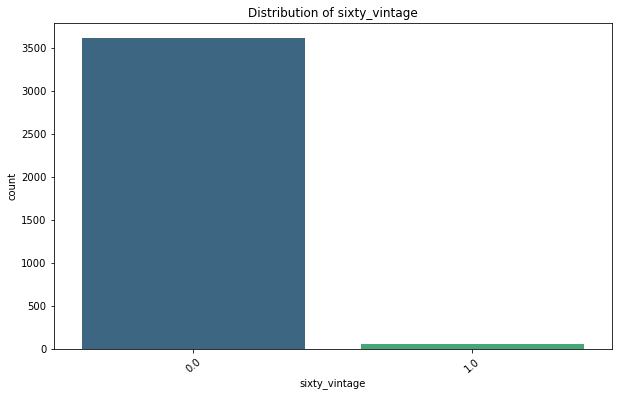

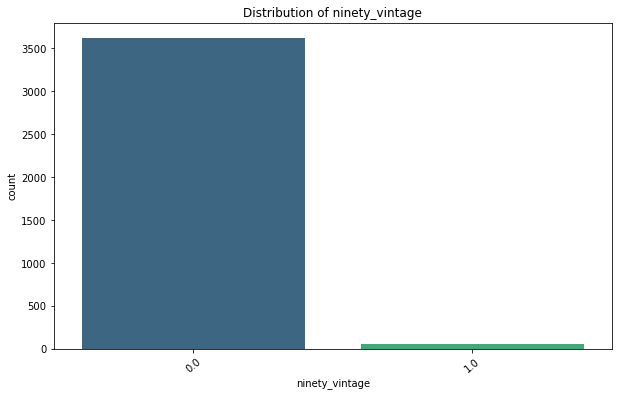

In [40]:
#распределение всех категориальных столбцов еще раз
categorical_cols = data_cleaned.select_dtypes(include='object')
for column in categorical_cols.columns:
    plt.figure(figsize=(10, 6)) 
    sns.countplot(data=categorical_cols, x=column, palette='viridis')  
    plt.xticks(rotation=40)  
    plt.title(f'Distribution of {column}')  
    plt.show()

Исходя из графиков и рассчитанных модальных значений, можно сделать вывод, что клиент, 
наиболее часто встречающийся в нашей выборке по категориальным признакам, имеет следующие характеристики: 

In [65]:
data_cleaned_mode= data_cleaned.mode().T
data_cleaned_mode.columns = ['Мода по каждой переменной'] 
data_cleaned_mode



,Мода по каждой переменной
INCOME_BASE_TYPE,Поступление зарплаты на счет
CREDIT_PURPOSE,Ремонт
INSURANCE_FLAG,1.0
DTI,0.59
SEX,мужской
FULL_AGE_CHILD_NUMBER,0
DEPENDANT_NUMBER,0
EDUCATION,высшее
EMPL_TYPE,специалист
EMPL_SIZE,>250


In [54]:
data_cleaned.age.mode() 
#самый часто встречающийся возраст - 29

0    29.0
Name: age, dtype: float64

In [55]:
data_cleaned.age.mean()
#однако мы воспринимаем переменную возраста как количественную переменную, поэтому корректнее взять средний возраст (36 лет)
#для "типичного" клиента

35.8014705882353

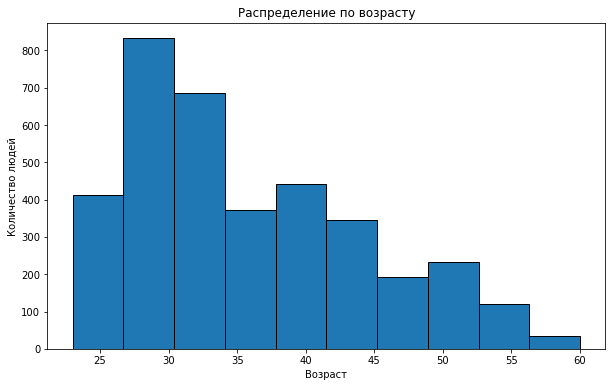

In [74]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot (111)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
ax.hist (data_cleaned.age, edgecolor='black', bins = 10);

ИТОГ: у нас получились максимально полные данные без пропусков и ошибок. Всего у нас 42 переменные (напоминаю, что айди мы сохранили для построения итоговой витрины данных). Имеем 23 количествеенных признака и 19 категориальных.
Теперь нам нужно перевести категориальные переменные (которые еще не закодированы) в численные для проведения кластеризации.

# ЧАСТЬ 2
Выделим сегменты клиентов с помощью метода k-means и построения решающего дерева.

In [75]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import calinski_harabasz_score


In [268]:
 # labelencoder = LabelEncoder()
df_encoded = data_cleaned.copy()
# df_encoded.loc[:, 'EDUCATION'] = labelencoder.fit_transform(df_encoded.loc[:, 'EDUCATION'])
#Я решила НЕ кодировать образование через labelencoding, так как  числовые значения могут быть неверно истолкованы 
#алгоритмами как имеющие некоторый порядок.
categorical_features = ['EDUCATION','SEX','INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'EMPL_TYPE',
                        'EMPL_SIZE', 'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS']
X_dum = pd.get_dummies(df_encoded[categorical_features], drop_first=True)
new_df = X_dum.join(df_encoded[df_encoded.columns.difference(categorical_features)])
df_original = copy.deepcopy(new_df)
new_df = new_df.astype(float)


Использую метод локтя для нахождения оптимального значения количества кластеров для метода k-means.

Построим график зависимости между значениями k и суммой квадрата остатков внутри кластера (сумма квадратов расстояний между каждой точкой и центроидом в кластере), чтобы получить значение k.  Мы видим, что это снижение резко замедляется, когда значение кластеров достигает 2 (будем считать, что это слишком мало и мы хотим получить более детальный анализ наших клиентов). Затем это же происходит после преодоления точки 4. Можно будет также проверить k=6, так как после этой точки тоже немного меняется угол. 

In [269]:
max_clusters = 10

# Сохраняем сумму квадратов расстояний от каждой точки до центроида для разного количества кластеров
distortions = []
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(new_df)
    distortions.append(kmeans.inertia_)

# Построение графика метода локтя
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя')
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

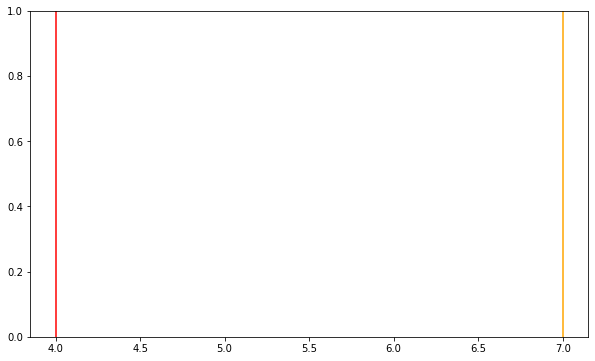

In [229]:
K = range(1,10)

# Plot the elbow
plt.figure(figsize=(10, 6))
plt.axvline(4, 0, 1, label='slope change #1', color='red')
plt.axvline(7, 0, 1, label='slope change #2', color='orange')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend();

Первым выбранным мною алгоритм сегментации является k-means.

Используем метод главных компонент и сингулярное разложение для снижения размерности (вопреки PCA сингулярное разложение не центрирует данные прежде, чем вычислять само разложение. Это означает, что может работать с разреженными матрицами эффективно, может пригодиться в случае если датафреймы большие и данные хранятся в разреженном виде).

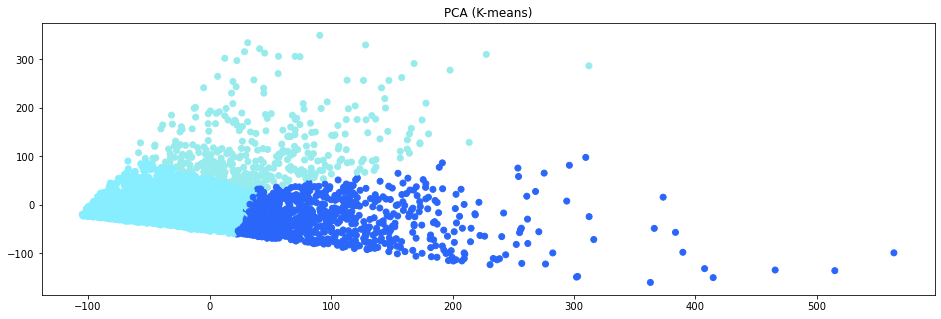

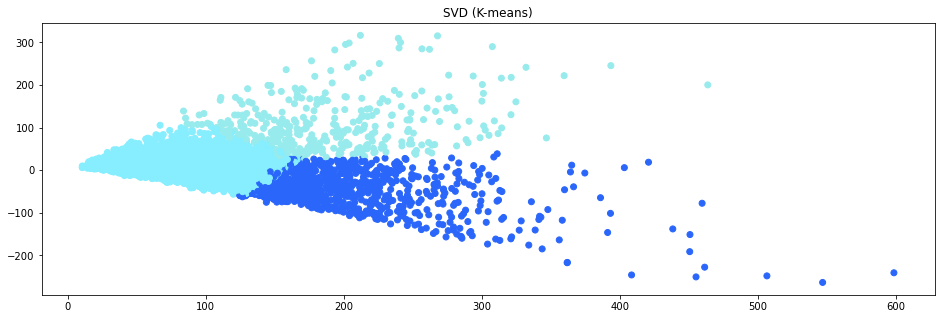

In [253]:
Y_pca = PCA(n_components=5).fit_transform(new_df);
Y_svd = TruncatedSVD(n_components=5).fit_transform(new_df);
K = 3
kmean = KMeans(n_clusters=K).fit(new_df) 
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmean.labels_))))

plt.figure(figsize=(16,5));
plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);


Коэффициент силуэта говорит нам, насколько хорошо назначена каждая отдельная точка. Если S(i) близок к 0, то он находится прямо в точке перегиба между двумя кластерами. Если он ближе к -1, то нам было бы лучше отнести его к другому кластеру. Если S(i) близок к 1, то точка хорошо назначена и может интерпретироваться как принадлежащая «подходящему» кластеру.

Коэффициент силуэта можно использовать для оценки качества кластеризации. Чем выше средний коэффициент силуэта для всех точек, тем лучше качество кластеризации.

In [217]:
labels = kmean.labels_
silhouette_avg = silhouette_score(new_df, labels)
print(f"Silhouette score для всего набора данных: {silhouette_avg}")



Silhouette score для всего набора данных: 0.4314323708698426


Глянем на модальное значение каждого регрессора в каждом кластере.



In [218]:
cluster_medians = []
for cluster in cluster_elements:
    cluster_median = np.median(cluster, axis=0)
    cluster_medians.append(cluster_median)

if 'columns' in dir(new_df):
    for i, cluster_median in enumerate(cluster_medians):
        print()
        print(f"Кластер {i + 1}:")
        for j, column_name in enumerate(new_df.columns):
            cluster_median_value = cluster_median[j]
            print(f"{column_name}: {cluster_median_value}")


Кластер 1:
EDUCATION_второе высшее: 0.0
EDUCATION_высшее: 1.0
EDUCATION_незаконченное высшее: 0.0
EDUCATION_среднее: 0.0
EDUCATION_среднее-специальное: 0.0
EDUCATION_ученая степень: 0.0
SEX_мужской: 0.0
INCOME_BASE_TYPE_Поступление зарплаты на счет: 0.0
INCOME_BASE_TYPE_Свободная форма с печатью работодателя: 0.0
INCOME_BASE_TYPE_Форма банка (без печати работодателя): 0.0
CREDIT_PURPOSE_Лечение: 0.0
CREDIT_PURPOSE_Обучение: 0.0
CREDIT_PURPOSE_Отпуск: 0.0
CREDIT_PURPOSE_Покупка автомобиля: 0.0
CREDIT_PURPOSE_Покупка бытовой техники: 0.0
CREDIT_PURPOSE_Покупка земли: 0.0
CREDIT_PURPOSE_Покупка мебели: 0.0
CREDIT_PURPOSE_Покупка недвижимости/ строительство: 0.0
CREDIT_PURPOSE_Ремонт: 1.0
EMPL_TYPE_другое: 0.0
EMPL_TYPE_менеджер высшего звена: 0.0
EMPL_TYPE_менеджер по продажам: 0.0
EMPL_TYPE_менеджер среднего звена: 0.0
EMPL_TYPE_рабочий: 0.0
EMPL_TYPE_специалист: 0.0
EMPL_TYPE_страховой агент: 0.0
EMPL_TYPE_торговый представитель: 0.0
EMPL_SIZE_>250: 1.0
EMPL_PROPERTY_Информационные тех

**Опишем получившиеся сегменты по основным самым важным (по моему мнению) регрессорам:**
#### Сегмент 1:
- Замужняя женщина 42 лет с высшим образованием
- Берущая кредит на ремонт
- Работающая вспомогательным персоналом, с отношением долга к доходу = 0.59
- Получающая зп в размере более 250 тыс./месяц с подтверждением налога 2НДФЛ (работодатель в сфере торговли ОПФ ООО)
- Имеющая открытый кредитный счет, но не имеющая онлайн кабинета
- Имеется просрочка и несколько кредитов, залога нет

#### Сегмент 2:
- Женатый мужчина 31 лет с высшим образованием
- Берущий кредит на ремонт
- Работающий вспомогательным персоналом, с отношением долга к доходу = 0.59
- Получающий зп в размере более 250 тыс./месяц с подтверждением налога 2НДФЛ (работодатель в сфере торговли ОПФ ООО)
- Имеющий открытый кредитный счет, но не имеющий онлайн кабинета
- Имеется просрочка, залог есть

#### Сегмент 3:
- Женатый мужчина 29 лет с высшим образованием
- Берущий кредит на ремонт
- Работающий вспомогательным персоналом, отношение долга к доходу = 0.49
- Получающий зп в размере более 250 тыс./месяц с подтверждением налога 2НДФЛ (работодатель в сфере торговли ОПФ ООО)
- Имеющий открытый кредитный счет, но не имеющий онлайн кабинета
- Есть кредиты, НЕ имеется просрочка, залога нет

Замечу, что несмотря на то, что метод локтя выделил k=4 и k=6, я при анализе получившихся сегментов заметила, что значения у переменных получаются практические одинаковые в нескольких сегментах сразу (то есть выделяются лишние секторы), поэтому мною было принято решение выделить всего 3 кластера. К тому же наивысшее значение коэффициента силуэта (то есть ситуация, когда кластеры максимально не похожи друг на друга и объекты внутри кластеров максимально схожи) достигается при k=3. На практике, как мне кажется, после моего анализа можно было бы уточнить у руководителя отдела, на сколько детальные сегменты мы хотим получить и после задать нужное число гиперпараметра.

Большинство наших клиентов:

• женаты\замужем,

• оформляют кредиты БЕЗ залога,

• имеют просрочки по кредитам,

• берут кредит на ремонт,

• ранее уже брали кредиты,

• получают высокую зарплату (более 250к в месяц) по 2НДФЛ,

• работают в торговле в качестве вспомогательного персонала

Сегментация без учителя при помощи k-means дала спорные результаты. Считаю, что нужно попробовать использовать другие методы обучения без учителя (например, иерархическую кластеризацию, dbscan) или использовать в целом другие методы кластеризации: обучение с учителем, rfm анализ, бизнес-правила.

In [127]:
mat = new_df.values #если нужно посмотреть, к какому кластеру отнесена каждый объект в датафрейме
km = KMeans(n_clusters=4)
km.fit(mat)
labels = km.labels_
results = pd.DataFrame([new_df.index,labels]).T
results

,0,1
0,6,0
1,11,3
2,14,0
3,16,0
4,21,0
...,...,...
3667,10232,0
3668,10233,0
3669,10235,0
3670,10236,2


In [ ]:
#глянем, как на графике рассеивания будут меняться кластеры в зависимости от значений гиперпараметра (изначального кол-ва кластеров)
plt.figure(figsize= (15,8))
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(new_df)
    clusters = k_means.predict(new_df)
    plt.subplot(2,3,n_c - 1)
    plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

plt.show()

Как мы видим, k-means обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации, зависит от заданного числа кластеров.

К ее преимуществам относятся масштабируемость, простота, гибкость и интерпретируемость.
К недостаткам можно отнести чувствительность к начальным условиям, сложность определения оптимального количества кластеров, ограниченность линейными границами и чувствительность к выбросам.
Для эффективного использования кластеризации K-means важно тщательно продумать начальные условия, количество кластеров и наличие провалов в данных.
Кластеризацию K-means следует использовать в сочетании с другими методами, чтобы получить более глубокое понимание данных.

Также есть вариация k-medians, которая использует медиану вместо среднего. Это позволяет алгоритму стать более устойчивым к выбросам.

In [ ]:
# еще раз омтечу, что наилучшее значение коэффициента силуэта получается при гиперпараметре кол-ва кластеров - 3
best_k, best_score = None, -1
for k in range(2,15):
    k_means = KMeans(n_clusters = k)
    k_means = k_means.fit(new_df)
    clusters = k_means.predict(new_df)
    score = np.round(silhouette_score(X=new_df,
                             labels=clusters), 2)
    if score > best_score:
      best_score = score
      best_k = k
print('Best score {}, k = {}'.format(best_score, best_k))

In [ ]:
results_sil_kmeans = {} #для наглядности
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(new_df)
    
    sil_score = silhouette_score(new_df, labels)
    results_sil_kmeans.update({i: sil_score})
plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans.keys()), list(results_sil_kmeans.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (K-means)')
plt.show()

**Calinski-Harabasz Index**

Оценка определяется как отношение внутрикластерной дисперсии к межкластерной дисперсии. Чем выше индекс, тем лучше результат.

Более высокое значение индекса Калински-Харабаша означает, что кластеры плотные и хорошо разделены, хотя нет никакого «приемлемого» порогового значения. Нам нужно выбрать то решение, которое дает пик или, по крайней мере, резкий изгиб на линейном графике индексов Калински-Харабаша. С другой стороны, если линия гладкая (горизонтальная, восходящая или нисходящая), то нет причин отдавать предпочтение одному решению перед другими.


Если средний индекс Калински-Харабаша близок к 1, то кластеризация очень хорошая.
Если средний индекс Калински-Харабаша находится между 0,5 и 1, то кластеризация хорошая.
Если средний индекс Калински-Харабаша находится между 0 и 0,5, то кластеризация приемлемая.
Если средний индекс Калински-Харабаша близок к 0, то кластеризация плохая.
Если средний индекс Калински-Харабаша близок к -1, то кластеризация очень плохая

In [ ]:
results_ch_kmeans = {}
for i in range(2, 8):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(new_df)
    
    ch_score = calinski_harabasz_score(new_df, labels)
    results_ch_kmeans.update({i: ch_score})
plt.figure(figsize=(15, 8))

plt.plot(list(results_ch_kmeans.keys()), list(results_ch_kmeans.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 8, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (K-means)')
plt.show() #видим, что для 3-4 кластеров значение индекса практически одинаковое (2 сегмента - это слишком мало)

# **Решающее дерево**

### Преимущества дерева:
- Очень понятно и интерпретируемо
- Допускаются разнотипные данные
- Возможность обхода пропусков

### Недостатки дерева:
- Сильная зависимость от используемых признаков и выбора таргета
- Подбор большого числа гиперпараметров (насколько мы хотим получить сложное дерево)

Для дерева мы выбрали признаки FAMILY_STATUS, EMPL_SIZE, EMPL_TYPE,DTI, SEX, AGE, ALL_CREDITS, NUMACCOUNTACTIVEALL, SUM_OF_PAYM_MONTHS, PERIOD_AT_WORK для понятной всем интерпретации. Также будем учитывать такие признаки, как dlq_exist, if_zalog, credit_purpose, education. В качестве таргета я выбрала income_base_type, тк у него относительно равномерное распределение значений, ведь мы хотим, чтобы соблюдался баланс класс, чтобы классификатор предсказывал не только доминирующий класс.

In [147]:
data_cleaned.INCOME_BASE_TYPE.value_counts()

INCOME_BASE_TYPE
Поступление зарплаты на счет              1318
Форма банка (без печати работодателя)     1034
2НДФЛ                                      946
Свободная форма с печатью работодателя     374
Name: count, dtype: int64

In [148]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_with_teacher = data_cleaned.copy()
df_with_teacher.loc[:, 'INCOME_BASE_TYPE'] = labelencoder.fit_transform(df_with_teacher.loc[:, 'INCOME_BASE_TYPE'])

df_with_teacher_cut = pd.get_dummies(df_with_teacher[['FAMILY_STATUS','EMPL_PROPERTY','INCOME_BASE_TYPE','if_zalog','SEX','DTI','dlq_exist','CREDIT_PURPOSE','age','all_credits','numAccountActiveAll','Period_at_work','sum_of_paym_months','EDUCATION',"EMPL_SIZE" ,'EMPL_TYPE']], drop_first=True)
# df_with_teacher_cut.INCOME_BASE_TYPE.value_counts() #сопоставим категории из ячейки вышем, запомним

In [170]:
labelencoder = LabelEncoder()
df_with_teacher = data_cleaned.copy()
df_with_teacher.loc[:, 'INCOME_BASE_TYPE'] = labelencoder.fit_transform(df_with_teacher.loc[:, 'INCOME_BASE_TYPE'])

df_with_teacher_cut = pd.get_dummies(df_with_teacher[['FAMILY_STATUS','EMPL_PROPERTY','INCOME_BASE_TYPE','if_zalog','SEX','DTI','dlq_exist','CREDIT_PURPOSE','age','all_credits','numAccountActiveAll','Period_at_work','sum_of_paym_months','EDUCATION',"EMPL_SIZE" ,'EMPL_TYPE']], drop_first=True)

# Объединение преобразованного датафрейма с исходным
# df_with_teacher = pd.concat([df_with_teacher, df_with_teacher_cut], axis=1)


In [177]:
labelencoder = LabelEncoder()
df_with_teacher = data_cleaned.copy()
df_with_teacher.loc[:, 'INCOME_BASE_TYPE'] = labelencoder.fit_transform(df_with_teacher.loc[:, 'INCOME_BASE_TYPE'])

df_with_teacher_cut = pd.get_dummies(df_with_teacher[['FAMILY_STATUS','EMPL_PROPERTY','INCOME_BASE_TYPE','if_zalog','SEX','DTI','dlq_exist','CREDIT_PURPOSE','age','all_credits','numAccountActiveAll','Period_at_work','sum_of_paym_months','EDUCATION',"EMPL_SIZE" ,'EMPL_TYPE']], drop_first=True)

# Заменить значения True и False на 1 и 0
df_with_teacher_cut = df_with_teacher_cut.replace({True: 1, False: 0})

# Преобразовать тип данных в int
df_with_teacher_cut = df_with_teacher_cut.astype(int)


In [178]:
y = df_with_teacher['INCOME_BASE_TYPE']
y_categorical = pd.Categorical(y)

X= df_with_teacher_cut
tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X,y_categorical)
predicted_classes = tree.predict(X)
predicted_classes_rounded = [round(value) for value in predicted_classes]


In [179]:
df_with_teacher.INCOME_BASE_TYPE.value_counts()

INCOME_BASE_TYPE
1    1318
3    1034
0     946
2     374
Name: count, dtype: int64

In [180]:
df_with_teacher_cut['predicted_class'] = predicted_classes_rounded

grouped_df = df_with_teacher_cut.groupby('predicted_class')

for predicted_class, group in grouped_df:
    print(f"Most frequent features for predicted class {predicted_class}:")
    mode_features = group.drop('predicted_class', axis=1).mode().iloc[0]
    print(mode_features)
    print()


Most frequent features for predicted class 0:
DTI                                                    0
age                                                   27
all_credits                                            3
numAccountActiveAll                                    1
Period_at_work                                         6
sum_of_paym_months                                    25
FAMILY_STATUS_гражданский брак                         0
FAMILY_STATUS_женат / замужем                          1
FAMILY_STATUS_повторный брак                           0
FAMILY_STATUS_разведен / разведена                     0
FAMILY_STATUS_холост / не замужем                      0
EMPL_PROPERTY_Информационные технологии                0
EMPL_PROPERTY_Сельское и лесное хозяйство              0
EMPL_PROPERTY_Торговля                                 0
EMPL_PROPERTY_Юридические услуги                       0
INCOME_BASE_TYPE_1                                     0
INCOME_BASE_TYPE_2                        

#### Сегмент 1:
- Женатый мужчина 49 лет с высшим образованием
- Категория кредита "другое"
- Работающий вспомогательным персоналом в категории "другое", с отношением долга к доходу = 0.59, давно работает 
- Получающий зп в размере более 250 тыс./месяц 
- Имеется открытый счет и кредит
- Сумма платежей за последний месяц 42 тыс
- Нет просрочки, залога нет

Комментарий: взрослый мужчина с большим опытом, не сильно активная кредитная история.  Клиентов данного сегмента необходимо привлекать и стимулировать их на совершение новых сделок, их можно назвать "спящими".

#### Сегмент 2:
- Замужняя женщина 27 лет с высшим образованием
- Берущая кредит на ремонт
- Работающая вспомогательным персоналом в торговле полгода, с отношением долга к доходу = 0.49
- Получающая зп в размере более 250 тыс./месяц 
- Имеется открытый счет и несколько кредитов
- Сумма платежей за последний месяц 16 тыс
- Имеется просрочка, залога нет

Комментарий: женщина хорошо зарабывает, достаточно молода, активно начинает пользоваться банковскими счетами и услугами. Это очень перспективные клиенты, которых нужно привлекать на открытие новых счетов.

#### Сегмент 3:
- Замужняя женщина 29 лет с высшим образованием
- Берущая кредит на ремонт
- Работающая вспомогательным персоналом год в торговле, с отношением долга к доходу = 0.59
- Получающая зп в размере < 50 тыс./месяц 
- Имеется  открытый счет
- Сумма платежей за последний месяц 41 тыс
- Имеется просрочка и несколько кредитов, залога нет

Комментарий: 80% з/п пошло на обслуживание долга, так как в данном сегменте у нас замужняя женщина, скорее всего семейный бюджет также включает доходы мужа, который обеспечивает семью. Эти клиенты также очень перспективные, так как это клиенты из семей, которые активно пользуются банковскими счетами и кредитами.

#### Сегмент 4:
- Женатый мужчина 38 лет с высшим образованием
- Берущий кредит на ремонт
- Работающая менеджер высшего звена полгода в торговле, с отношением долга к доходу = 0.18
- Получающая зп в размере < 50 тыс./месяц  
- Имеется несколько открытых счетов
- Сумма платежей за последний месяц 5 тыс
- Имеется просрочка и есть кредит, есть залог

Комментарий: странно, что менджер высшего звена зарабатывает меньше 50 тысяч (однако стоит учитывать, что он работает всего полгода). Сумма месячного платежа соизмерима с размером зарплаты и неудивильно наличие просрочки. В среднем клиенты в этом сегменте брали кредит более чем разово, значит это для них актуально. Но, вероятнее всего, из-за низкой заработной платы клиенты итак будут обращаться за услугами в банк из-за недостаточности денег на руках.

Обратим внимание, что во всех сегментах у клиентов есть семьи и высшее образование. Также преобладающей причиной взятия кредита оказался ремонт. Стоит обращать внимание на активных клиентов с целью их удержания и предлагать им персональные скидки, условия, договоры. Также стоит пытаться разбудить "спящих" клиентов, чтобы они активнее пользовались услугами банка.

Результаты сегментации, полученные после обучения решающего дерева, показались мне более релевантными: он дает более разнородные сегменты, более детализированные, чем метод k-means, также для решающего дерева можно не делать такую подробную предобработку данных, так как он сам справляется с обработкой, например, пропусков и разных типов данных, что делает метод более автоматизированным.